In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns  

In [46]:
# load data and get some insight
pdata = pd.read_excel("data.xlsx")
pdata.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [47]:
# Remove 0 and 1 indices since those are not needed
pdata.drop(pdata.columns[[0,1]], inplace=True, axis=1)
unique_values = pdata.nunique()
print('Count unique values in each column')
print(unique_values)

Count unique values in each column
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64


In [48]:
pdata.info

<bound method DataFrame.info of      Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0              100000                   2                  1   
1               50000                   3                  0   
2               50000                   7                  1   
3               30000                   5                  1   
4              100000                   6                  0   
..                ...                 ...                ...   
655             99000                  10                  1   
656             84000                  10                  1   
657            145000                   8                  1   
658            172000                  10                  1   
659            167000                   9                  0   

     Total_visits_online  Total_calls_made  
0                      1                 0  
1                     10                 9  
2                      3                 4  
3                  

In [49]:
pdata.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


In [50]:
print("Missing values:\n{}".format(pdata.isnull().sum()))

Missing values:
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64


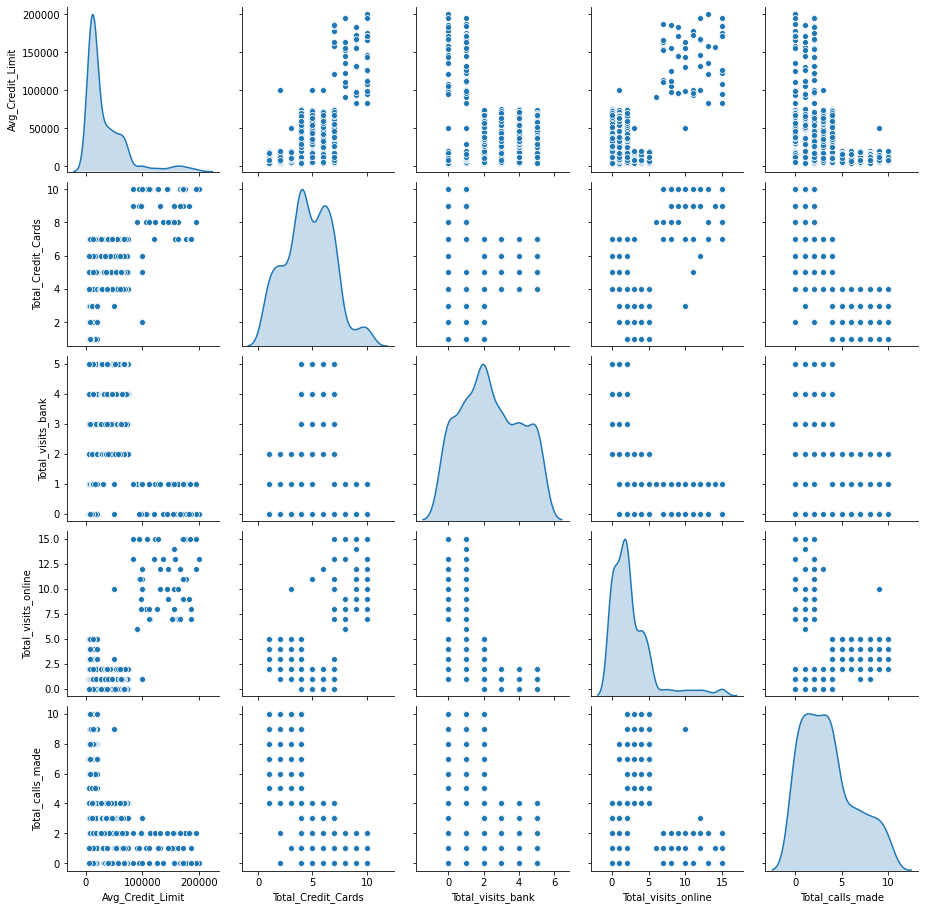

In [51]:
sns.pairplot(pdata, diag_kind='kde') 

In [52]:
# Based on the kde plots above, we can work with 2 or 3 clusters
from scipy.stats import zscore
pdata_z = pdata.apply(zscore)

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

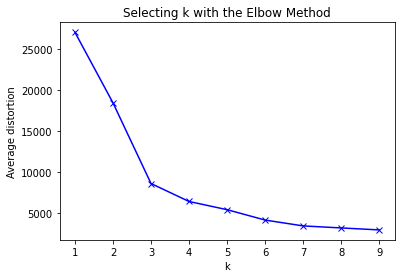

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(pdata)
    prediction=model.predict(pdata)
    meanDistortions.append(sum(np.min(cdist(pdata, model.cluster_centers_, 'euclidean'), axis=1)) / pdata
                           .shape[0])

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

In [54]:
#Set the value of k=3
kmeans = KMeans(n_clusters=3, n_init = 15, random_state=2345)

In [55]:
kmeans.fit(pdata_z)

KMeans(n_clusters=3, n_init=15, random_state=2345)

In [56]:
centroids = kmeans.cluster_centers_

In [57]:
centroids
centroid_df = pd.DataFrame(centroids, columns = list(pdata_z) )
print(centroid_df)


Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0         -0.595796           -1.059623          -0.901518   
1         -0.021062            0.373690           0.666395   
2          2.831764            1.862226          -1.105763   

   Total_visits_online  Total_calls_made  
0             0.322997          1.148109  
1            -0.553672         -0.553005  
2             2.827319         -0.874330  


In [58]:
# Cluster 0 has the lowest values and cluster 2 has the highest values
## creating a new dataframe only for labels and converting it into categorical variable
df_labels = pd.DataFrame(kmeans.labels_ , columns = list(['labels']))

df_labels['labels'] = df_labels['labels'].astype('category')

In [59]:
df_labeled = pdata.join(df_labels)
df_analysis = (df_labeled.groupby(['labels'] , axis=0)).head(4177)
df_analysis

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,100000,2,1,1,0,1
1,50000,3,0,10,9,0
2,50000,7,1,3,4,1
3,30000,5,1,1,4,1
4,100000,6,0,12,3,2
...,...,...,...,...,...,...
655,99000,10,1,10,0,2
656,84000,10,1,13,2,2
657,145000,8,1,9,1,2
658,172000,10,1,15,0,2


In [60]:
df_labeled['labels'].value_counts()  

1    386
0    224
2     50
Name: labels, dtype: int64

Text(0.5, 0.92, '3D plot of KMeans Clustering')

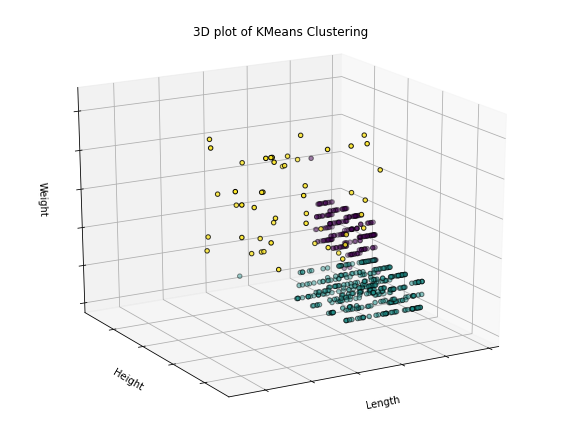

In [61]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=60)
kmeans.fit(pdata_z)
labels = kmeans.labels_
ax.scatter(pdata_z.iloc[:, 0], pdata_z.iloc[:, 1], pdata_z.iloc[:, 3],c=labels.astype(np.float), edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Length')
ax.set_ylabel('Height')
ax.set_zlabel('Weight')
ax.set_title('3D plot of KMeans Clustering')